In [1]:
#Path has been added to include the permutation functions
import sys
import os
sys.path.append(os.path.join(os.getcwd() , ".." , "Python_scripts"))

In [2]:
#libraries
import scanpy as sc
import pandas as pd
import numpy as np
import copy
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import random
from permutation import freq_to_link_table , calculate_statistic , run_permutation_parallel
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

In [5]:
#Set seed
seed_number = 42

random.seed(seed_number)     # python random generator
np.random.seed(seed_number)  # numpy random generator

In [6]:
#Read in meta data
chicken_meta = pd.read_csv(os.path.join(os.getcwd() , ".." , "metadata" , "larry_chicken.csv"))
human_meta = pd.read_csv(os.path.join(os.getcwd() , ".." , "metadata" , "larry_human.csv"))

In [7]:
#Cell types of interest
#Chicken
chicken_cell_types = ["RP" , "dp1_2" , "dI1", "dI2", "dI3" , "dpL"  ,"dI4_dILA" , "dI5_dILB" , "dp6" , "dI6" , "p0" , "V0" , "p1" , "V1" , "p2", "V2a" ,"V2b" , "pMN", "MN" , "OPCs" ,"p3","V3","FP"]
chicken_neurons = ["dI1", "dI2", "dI3"  ,"dI4_dILA" , "dI5_dILB"  , "dI6" , "V0" , "V1", "V2a" ,"V2b" , "MN","V3"]
#Human
human_cell_types = ["RP-dp1" , "dp1-3","dI1","dI2/3","dpL","dI4_dILA","dI5_dILB","dp6/p2","dI6","V0" ,"V1" ,"V2" ,"pMN/p3", "MN" , "OPCs","V3","FP"]
human_neurons = ["dI1","dI2/3","dI4_dILA","dI5_dILB","dI6","V0" ,"V1" ,"V2", "MN","V3"]

cell_type_data = {"chicken" : chicken_cell_types, "human" : human_cell_types}
neuron_data = {"chicken" : chicken_neurons, "human" : human_neurons}

In [8]:
#Select meta data for cell types of interest
chicken_meta_interest = chicken_meta[chicken_meta["cell_type"].isin(chicken_cell_types)]
human_meta_interest = human_meta[human_meta["cell_type"].isin(human_cell_types)]

meta_data = {"chicken" : chicken_meta_interest, "human" : human_meta_interest}

In [9]:
#Select organism of interest ("human" or "chicken")
organ_interest = "chicken"

In [10]:
#Select chicken_meta_interest or human_meta_interest
meta_interest = meta_data[organ_interest]
cell_types_interest = cell_type_data[organ_interest]
neurons = neuron_data[organ_interest]

In [11]:
#Remove cells without a clone assigned to it
meta_clone = meta_interest[~pd.isna(meta_interest["clone"])]

In [12]:
#Get amount of cells per clone/Cell type combination
clone_celltype_combo = meta_clone.groupby(["clone" , "cell_type"]).size().reset_index(name = "amount")
#Reshape data
clone_celltype_combo_wide = clone_celltype_combo.pivot(index = "clone" , columns="cell_type" , values = "amount").fillna(0).astype("int")

In [13]:
#If you want neurons only plot set neurons_only to True otherwise False
neurons_only = True

In [14]:
#Helper function to save plots recursively
import os
import matplotlib.pyplot as plt

def save_plot(plot_name):
    # Determine base folder by organ
    plot_dir = os.path.join("plots", organ_interest)
    os.makedirs(plot_dir, exist_ok=True)

    # Build suffixes
    suffix = "_neurons" if neurons_only else ""
    interaction_suffix = f"_{type_of_interaction}" if type_of_interaction == "between_within" else ""

    # Final path
    filename = f"{plot_name}{suffix}{interaction_suffix}.pdf"
    save_path = os.path.join(plot_dir, filename)

    # Save active figure
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    print(f"✅ Plot saved to {save_path}")



## Jaccard similarity

In [15]:
#Dictionay with celltypes as keys and clone names as values
celltype_clones = {celltype : set(clone_celltype_combo_wide[clone_celltype_combo_wide[celltype] > 0].index) for celltype in clone_celltype_combo_wide.columns}

In [16]:
# Initialize an empty DataFrame
jaccard_matrix = pd.DataFrame(index=cell_types_interest, columns=cell_types_interest, dtype=float)
# Initialize an empty DataFrame
clones_shared = pd.DataFrame(index=cell_types_interest, columns=cell_types_interest, dtype=float)
# Fill in the Jaccard similarity
for k1 in cell_types_interest:
    for k2 in cell_types_interest:
        
        
        
        if k1 == k2:
            jaccard_matrix.loc[k1, k2] = 0
            clones_shared.loc[k1, k2] = clone_celltype_combo_wide[(clone_celltype_combo_wide[k1] > 1)].shape[0]
        else:
            clones_shared.loc[k1, k2] = clone_celltype_combo_wide[(clone_celltype_combo_wide[k1] > 0) & (clone_celltype_combo_wide[k2] > 0)].shape[0]
            intersection = len(celltype_clones[k1] & celltype_clones[k2])
            union = len(celltype_clones[k1] | celltype_clones[k2])
            jaccard = intersection / union if union > 0 else 0
            jaccard_matrix.loc[k1, k2] = np.log(jaccard * 100 + 1e-20)


In [17]:
clones_shared

,RP,dp1_2,dI1,dI2,dI3,dpL,dI4_dILA,dI5_dILB,dp6,dI6,...,V1,p2,V2a,V2b,pMN,MN,OPCs,p3,V3,FP
RP,39.0,8.0,8.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,3.0,2.0,0.0,2.0,2.0,3.0,0.0,0.0,1.0
dp1_2,8.0,20.0,26.0,10.0,6.0,22.0,30.0,17.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
dI1,8.0,26.0,18.0,9.0,1.0,13.0,16.0,11.0,0.0,1.0,...,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
dI2,1.0,10.0,9.0,1.0,1.0,8.0,10.0,7.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dI3,0.0,6.0,1.0,1.0,4.0,13.0,17.0,9.0,0.0,1.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
dpL,1.0,22.0,13.0,8.0,13.0,201.0,263.0,175.0,15.0,20.0,...,17.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
dI4_dILA,1.0,30.0,16.0,10.0,17.0,263.0,256.0,210.0,12.0,19.0,...,15.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0
dI5_dILB,0.0,17.0,11.0,7.0,9.0,175.0,210.0,152.0,8.0,17.0,...,10.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
dp6,0.0,0.0,0.0,0.0,0.0,15.0,12.0,8.0,10.0,10.0,...,17.0,4.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
dI6,0.0,0.0,1.0,0.0,1.0,20.0,19.0,17.0,10.0,23.0,...,14.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


NameError: name 'type_of_interaction' is not defined

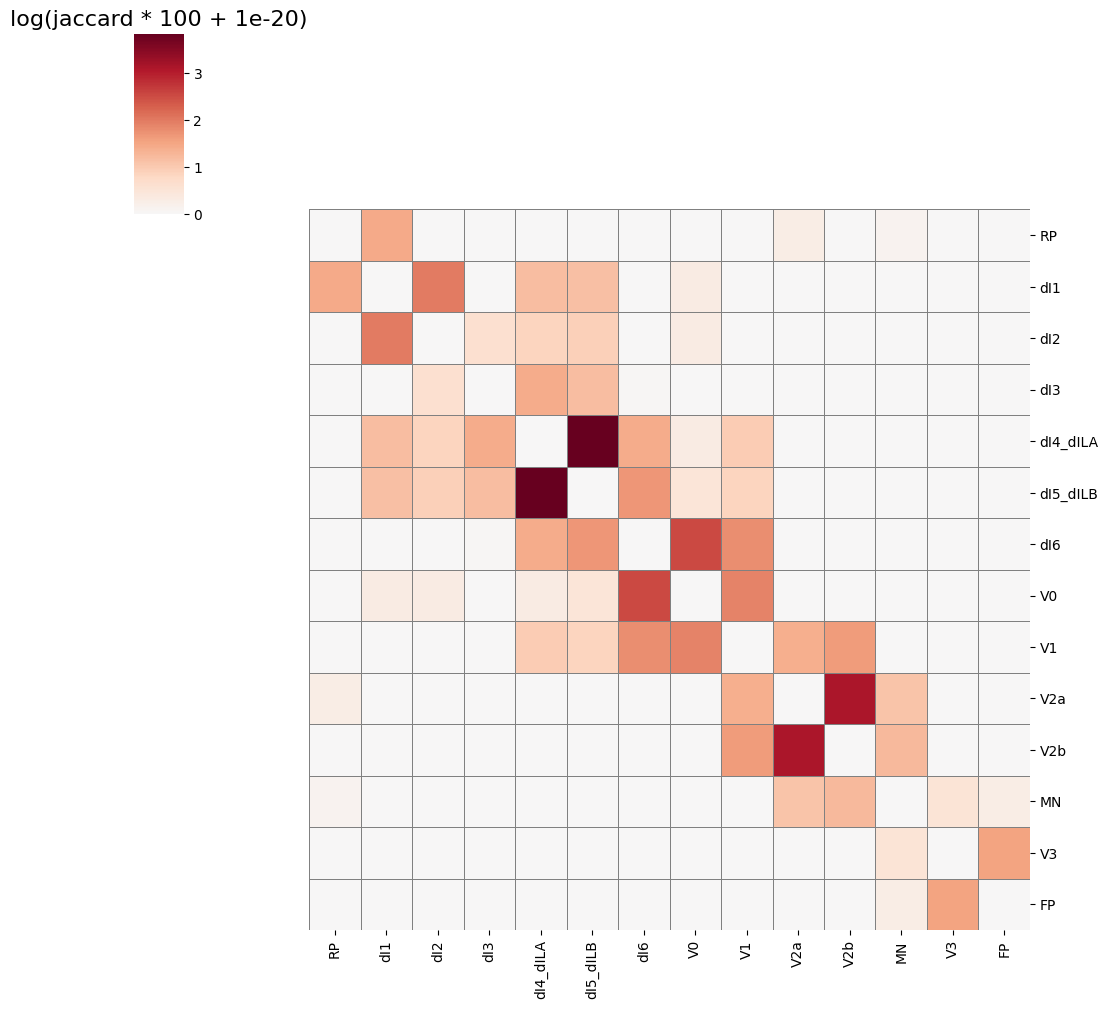

In [18]:
#Fill the NA values
X = jaccard_matrix

if neurons_only:
    X = jaccard_matrix.loc[neurons,neurons]

# Overlay heatmap for significant values with higher alpha


sns.clustermap(
    X,
    cmap='RdBu_r',
    vmin=0,
    center=0,
    row_cluster=False,
    col_cluster=False,
    linewidths=0.5,
    linecolor='grey',
    figsize=(10, 10),
    method = "ward"
)

title_text = "log(jaccard * 100 + 1e-20)"

# Set the title
plt.title(title_text, fontsize=16)

save_plot("clone_jaccard_heatmap")

plt.show()
plt.clf()

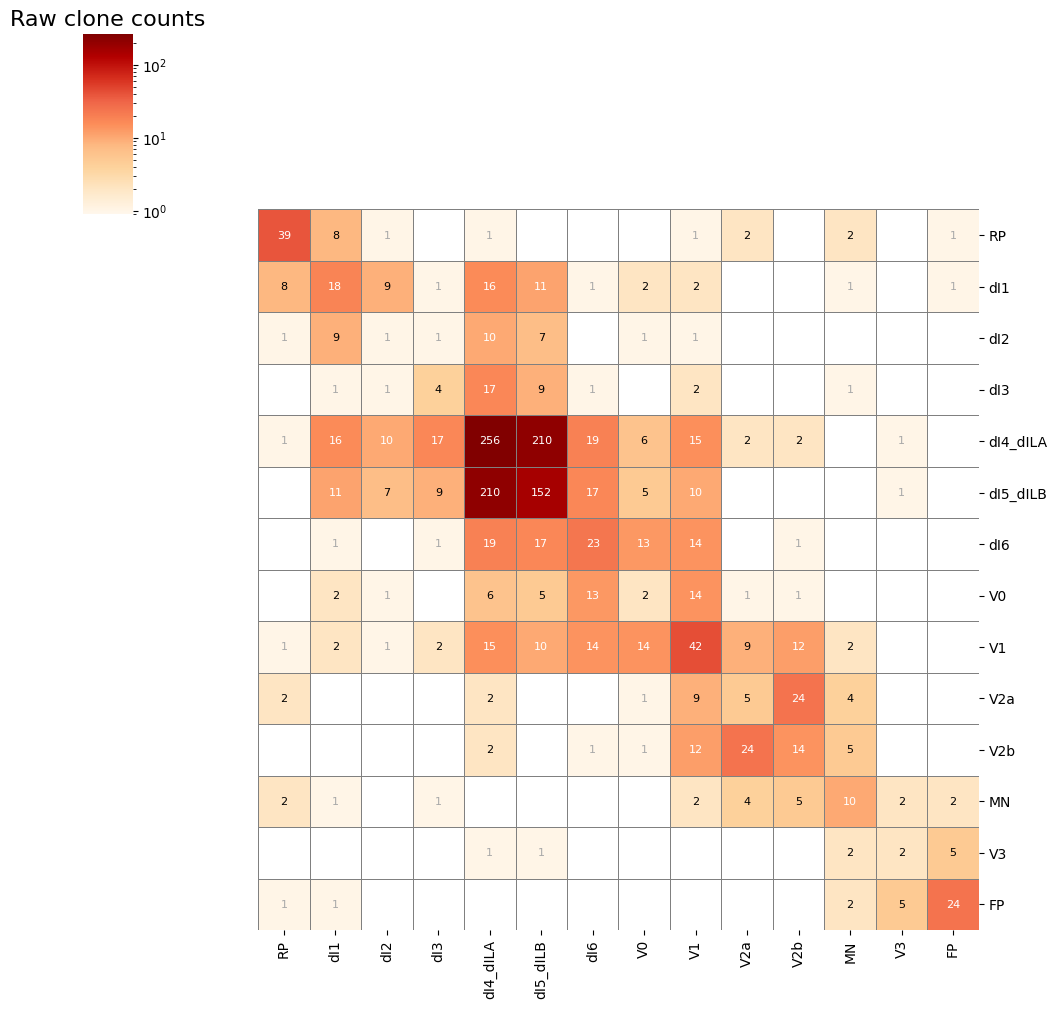

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm

X = clones_shared

if neurons_only:
    X = clones_shared.loc[neurons,neurons]



# Plot the clustermap
g = sns.clustermap(
    X,
    cmap="OrRd",
    norm=LogNorm(vmin=0.9, vmax=clones_shared.max().max()),
    row_cluster=False,
    col_cluster=False,
    linewidths=0.5,
    linecolor='grey',
    figsize=(10, 10)
)

# Extract heatmap data and axis AFTER plotting
data = g.data2d.values
ax = g.ax_heatmap

# Add centered integer labels > 0
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        val = data[i, j]
        if val > 0 and np.isclose(val, round(val)):
            if val == 1:
                text_color = 'darkgray'
            elif val < 10:
                text_color = 'black'
            else:
                text_color = 'white'

            ax.text(j + 0.5, i + 0.5, str(int(round(val))),
                    ha='center', va='center',
                    color=text_color,
                    fontsize=8,
                    transform=ax.transData)

# Set the title
title_text = "Raw clone counts"

# Set the title
plt.title(title_text, fontsize=16)

#save_plot("raw_clones_heatmap")

plt.show()
plt.clf()


## Permutation test

In [20]:
#Number of permutations
number_permutations = 1000

In [21]:
#Option of the permutation function with two possibilities:
## between: excludes interactions between cells of the same type
## between_within: includes interactions between cells of the same type
type_of_interaction = "between_within"

In [22]:
#Option of the permutation function with four options
## combination: The weight of the connection between two different cell types within a clones is the product of their amount.
## min_link: The weight of the connection between two different cell types within a clones is the minimum of their amount.
## sum: The weight of the connection between two different cell types within a clones is the sum of their amount, both amounts should be bigger than 0.
## connection: The weight of the connection between two different cell types within a clones is 1/0, based on the presence/absence of their co-occurrence. 
cell_combo_method = "sum"

In [23]:
#Calculate the pairwise connection frequency table for our data
interaction_table = freq_to_link_table(clone_celltype_combo_wide , interaction_type = type_of_interaction ,cell_combo_method = cell_combo_method)

In [24]:
#Calculate test statistic for our data
statistic = calculate_statistic(interaction_table)

In [25]:
#Run permutation tests
permutation_results  = run_permutation_parallel(clone_celltype_combo_wide , type_of_interaction , n_jobs = 32 , cell_combo_method = cell_combo_method , number_permutations = number_permutations)

Processing elements: 100%|██████████| 1000/1000 [03:42<00:00,  4.49it/s]


In [26]:
#Calculate statistics in respect to permutation distribution
FC_data = pd.DataFrame({"observed_statistic" : statistic.values() , 'permutation_mean' : np.mean(pd.DataFrame(permutation_results),axis = 0),'permutation_std' : np.std(pd.DataFrame(permutation_results),axis = 0) , 'permutation_max' : pd.DataFrame(permutation_results).max() , 'permutation_min' : pd.DataFrame(permutation_results).min()})

#Calculate Fold Change
FC_data["FC"] = FC_data["observed_statistic"] / FC_data["permutation_mean"] 

#Min Max normalisation
FC_data["min_max_norm"] = (FC_data["observed_statistic"] - FC_data["permutation_min"]) / (FC_data["permutation_max"] - FC_data["permutation_min"])

#Z score
FC_data["zscore"] = (FC_data["observed_statistic"] - FC_data["permutation_mean"]) / (FC_data["permutation_std"])

In [27]:
#Statistic of choice
stat_choice = "zscore"
zscores = {combo: 0 if np.isnan(FC) else FC for combo , FC in zip(FC_data.index , FC_data[stat_choice] )}

### Plot z-score matrix

In [28]:
# #Order of plotting
# plot_order = cell_types_interest

# #Create the zscore data matrix
# zscore_matrix = pd.DataFrame(index=plot_order, columns=plot_order)
# for combination , zscore in zscores.items():
#     el1 = combination.split("|")[0]
#     el2 = combination.split("|")[1]

#     zscore_matrix.at[el1 , el2] = zscore
#     zscore_matrix.at[el2 , el1] = zscore

# #Inspect zscore_matrix
# zscore_matrix

# #Calculate the correlation in co-occurrence pattern between cell types
# lineag_coupling_corr = copy.deepcopy(zscore_matrix)

# cell_types = zscore_matrix.columns

# #Calculate pearson correlation for every cell type combination
# for cell_type_len in range(len(cell_types)):
#     for cell_type_2 in cell_types[cell_type_len:]:
#         cell_type_1 = cell_types[cell_type_len]

#         one = pd.DataFrame(zscore_matrix[cell_type_1].drop([cell_type_1,cell_type_2]))[cell_type_1]
#         two = pd.DataFrame(zscore_matrix[cell_type_2].drop([cell_type_1,cell_type_2]))[cell_type_2]

#         lineag_coupling_corr.at[cell_type_1 , cell_type_2] = st.pearsonr(one , two).statistic
#         lineag_coupling_corr.at[cell_type_2 , cell_type_1] = lineag_coupling_corr.at[cell_type_1 , cell_type_2]

# #Select only neuron if selected
# if neurons_only:
#     zscore_matrix = zscore_matrix.loc[neurons,neurons]
#     clones_shared = clones_shared.loc[neurons,neurons]
#     plot_order = neurons

####

# Order of plotting
plot_order = cell_types_interest

# Create the z-score data matrix
zscore_matrix = pd.DataFrame(index=plot_order, columns=plot_order)
for combination, zscore in zscores.items():
    el1, el2 = combination.split("|")
    zscore_matrix.at[el1, el2] = zscore
    zscore_matrix.at[el2, el1] = zscore

# Initialize correlation matrix
lineag_coupling_corr = pd.DataFrame(index=zscore_matrix.columns, columns=zscore_matrix.columns)
cell_types = zscore_matrix.columns

# Calculate Pearson correlation for every cell type combination (including diagonals)
for cell_type_len in range(len(cell_types)):
    for cell_type_2 in cell_types[cell_type_len:]:
        cell_type_1 = cell_types[cell_type_len]

        # Extract full columns, keep diagonals, coerce to float
        one = pd.to_numeric(zscore_matrix[cell_type_1], errors='coerce')
        two = pd.to_numeric(zscore_matrix[cell_type_2], errors='coerce')

        # # Drop NaNs from both
        valid_idx = one.notna() & two.notna()
        one_clean = one[valid_idx]
        two_clean = two[valid_idx]

        # Calculate Pearson r if enough data
        if len(one_clean) > 1:
            r = st.pearsonr(one_clean, two_clean).statistic
        else:
            r = np.nan

        # Fill symmetrically
        lineag_coupling_corr.at[cell_type_1, cell_type_2] = r
        lineag_coupling_corr.at[cell_type_2, cell_type_1] = r

# Select only neurons if selected
if neurons_only:
    zscore_matrix = zscore_matrix.loc[neurons, neurons]
    clones_shared = clones_shared.loc[neurons, neurons]
    plot_order = neurons




In [29]:
#Fill the NA valuesx
X = np.array(zscore_matrix.fillna(0))

✅ Plot saved to plots/chicken/clone_zscore_heatmap_new_neurons_between_within.pdf


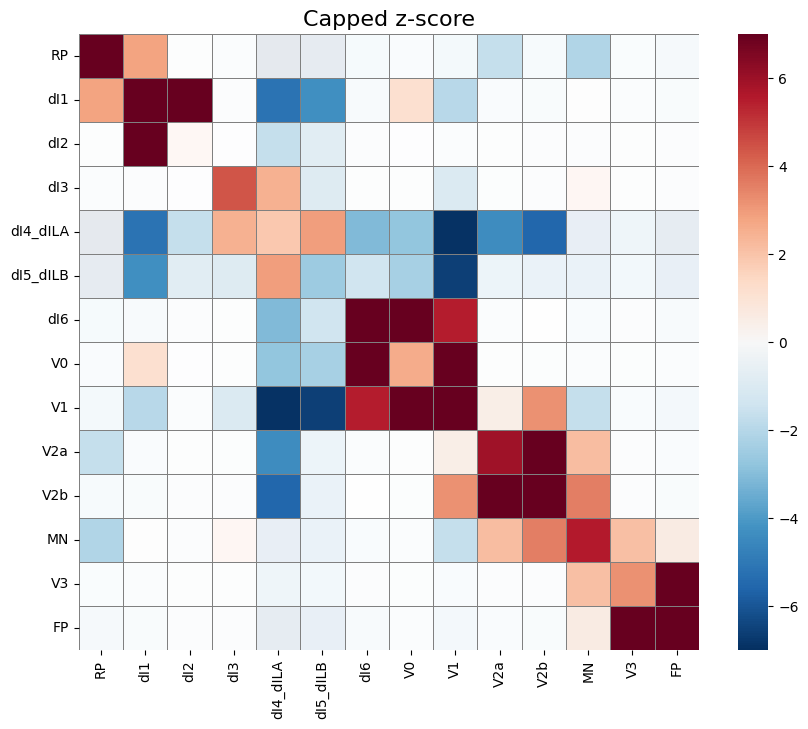

<Figure size 640x480 with 0 Axes>

In [30]:
#Fill the NA values
X = np.array(zscore_matrix.fillna(0))

plt.figure(figsize=(10, 8))

mask = np.array(clones_shared) < 2


# Base layer: low alpha (faded values for all cells)
sns.heatmap(
    X,
    cmap='RdBu_r',
    vmin=-7,
    vmax=7,
    center=0,
    linewidths=0.5,
    linecolor='grey',
    xticklabels=plot_order,
    yticklabels=plot_order,
    alpha=0.1,
    cbar=False
)


# Top layer: high alpha, mask low-confidence cells
sns.heatmap(
    X,
    mask=mask,
    cmap='RdBu_r',
    vmin=-7,
    vmax=7,
    center=0,
    linewidths=0.5,
    linecolor='grey',
    xticklabels=plot_order,
    yticklabels=plot_order,
    alpha=1.0
)


title_text = "Capped z-score"

# Set the title
plt.title(title_text, fontsize=16)


save_plot("clone_zscore_heatmap")

# Then show/clear
plt.show()
plt.clf()


### Plot correlation matrix

✅ Plot saved to plots/chicken/clone_correlation_heatmap_new_neurons_between_within.pdf


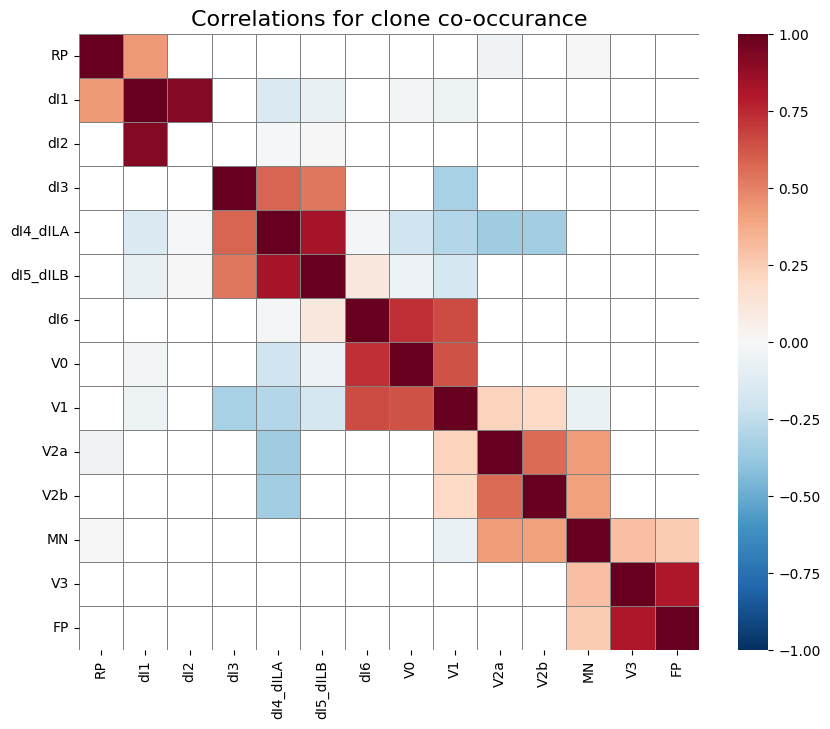

<Figure size 640x480 with 0 Axes>

In [31]:
#Select only neuron if selected
if neurons_only:
    lineag_coupling_corr = lineag_coupling_corr.loc[neurons,neurons]
    plot_order = neurons

#Fill the NA values
X = np.array(lineag_coupling_corr.fillna(0))


plt.figure(figsize=(10, 8))

mask = np.array(clones_shared) < 2

sns.heatmap(X, 
            mask = mask, 
            linewidths=0.5,linecolor='grey',
            alpha=1.0, 
            xticklabels = plot_order , yticklabels = plot_order, vmin=-1, vmax=1 , 
            cmap='RdBu_r', center=0)

title_text = "Correlations for clone co-occurance"

# Set the title for the colorbar
plt.title(title_text, fontsize=16)

save_plot("clone_correlation_heatmap")

plt.show()
plt.clf()

### Plot correlation matrix with corresponding z-score
Correlation matrix and z-score values must have the same sign. otherwise they are taken out.

In [32]:
#Compare zscore sign with correlation sign
same_sign = np.sign(lineag_coupling_corr) == np.sign(zscore_matrix.fillna(0))

✅ Plot saved to plots/chicken/clone_correlation_concordant_heatmap_new_neurons_between_within.pdf


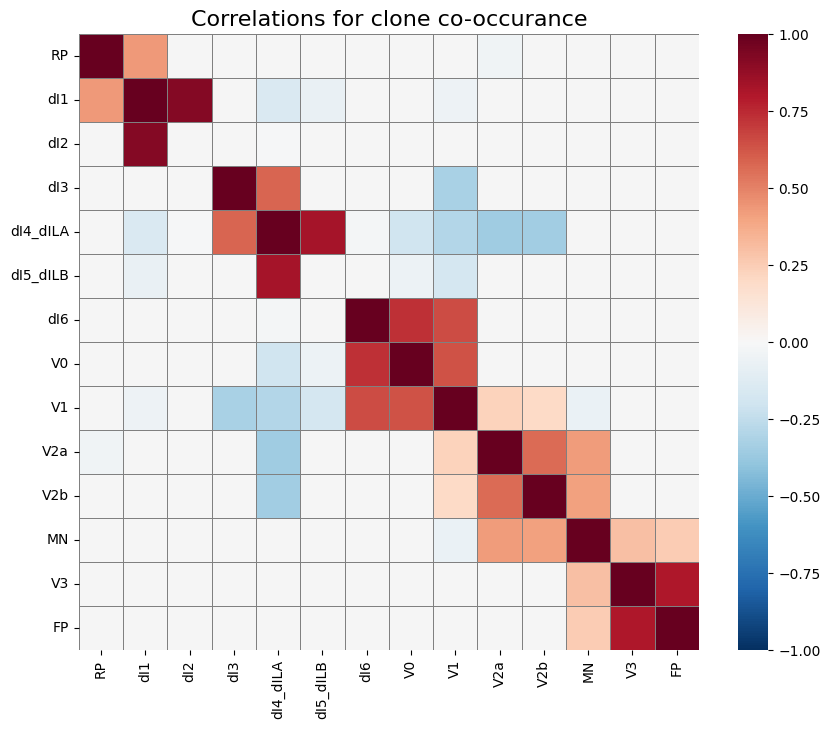

<Figure size 640x480 with 0 Axes>

In [33]:
#Only correlation with corresponding zscore sign
corresponding_sign = lineag_coupling_corr.where(same_sign)

#Select only neuron if selected
if neurons_only:
    corresponding_sign = corresponding_sign.loc[neurons,neurons]
    plot_order = neurons

#Fill the NA values
X = np.array(lineag_coupling_corr.where(same_sign), dtype = float)

# mask = np.isnan(X)
mask = np.array(clones_shared) < 2

plt.figure(figsize=(10, 8))

sns.heatmap(X, alpha=1.0, mask = mask,linewidths=0.5,linecolor='grey',xticklabels = plot_order , yticklabels = plot_order, vmin=-1, vmax=1 , cmap='RdBu_r', center=0)
plt.gca().set_facecolor('whitesmoke')

title_text = "Correlations for clone co-occurance"

# Set the title for the colorbar
plt.title(title_text, fontsize=16)

save_plot("clone_correlation_concordant_heatmap")

plt.show()
plt.clf()

### Hierarchical clustering of zscore

✅ Plot saved to plots/chicken/clone_hierarhical_zscore_heatmap_new_neurons_between_within.pdf


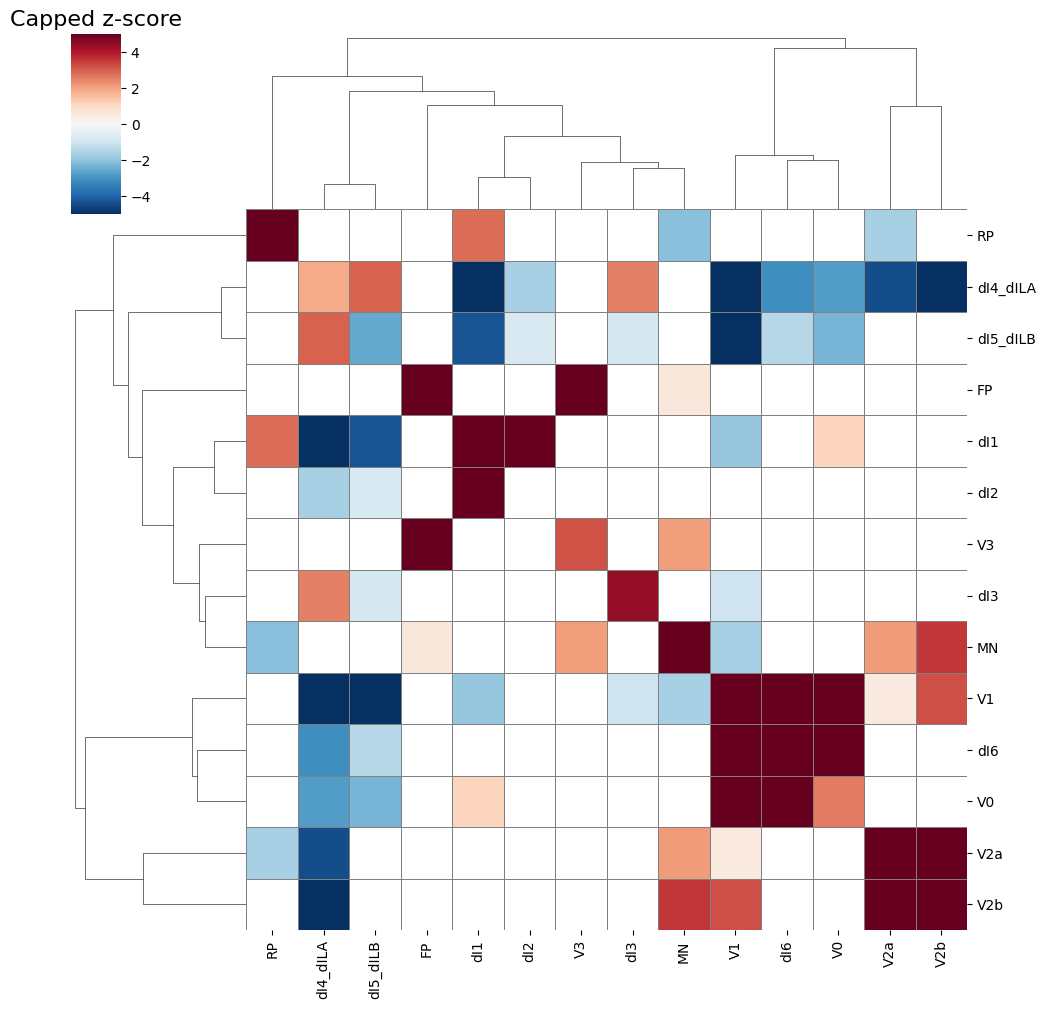

<Figure size 640x480 with 0 Axes>

In [34]:
#Fill the NA values
X = zscore_matrix.fillna(0)

if neurons_only:
    X = X.loc[neurons,neurons]



# Overlay heatmap for significant values with higher alpha
mask = np.array(clones_shared) < 2

sns.clustermap(
    X,
    mask = mask,
    cmap='RdBu_r',
    vmin=-5,
    vmax=5,
    center=0,
    row_cluster=True,
    col_cluster=True,
    linewidths=0.5,
    linecolor='grey',
    figsize=(10, 10),
    method = "ward"
)

title_text = "Capped z-score"

# Set the title
plt.title(title_text, fontsize=16)

save_plot("clone_hierarhical_zscore_heatmap")

plt.show()
plt.clf()

### Hierarchical clustering of correlation matrix with corresponding z-score

In [35]:
# 1. Fill the NA values and restrict to neuron subset if needed
X = lineag_coupling_corr.where(same_sign)

if neurons_only:
    X = X.loc[neurons,neurons]

X_fillna = X.fillna(0)

# 2. Compute linkage
all_linkage = linkage(pdist(X_fillna.values), method='ward')

In [36]:

# 3. Define recursive resolve function
def resolve(cluster_id, labels, linkage_matrix):
    """
    Recursively resolve the members of a cluster by ID using the linkage matrix.

    Parameters:
    - cluster_id: int, cluster index (>= len(labels) means non-leaf)
    - labels: list of leaf labels (e.g., cell types)
    - linkage_matrix: the hierarchical clustering linkage matrix

    Returns:
    - list of leaf labels in this cluster
    """
    if cluster_id < len(labels):
        return [labels[cluster_id]]
    else:
        cluster_id -= len(labels)
        left = int(linkage_matrix[cluster_id][0])
        right = int(linkage_matrix[cluster_id][1])
        return resolve(left, labels, linkage_matrix) + resolve(right, labels, linkage_matrix)

# 4. Inspect clusters (e.g., bottom-up or top-down)
labels = X_fillna.columns.tolist()
n = len(labels)

print("=== Inspecting last few cluster merges ===")
for i in reversed(range(n, len(all_linkage) + n)):
    members = resolve(i, labels, all_linkage)
    print(f"Row {i - n}: {members}")

=== Inspecting last few cluster merges ===
Row 12: ['dI3', 'dI4_dILA', 'dI5_dILB', 'V1', 'dI6', 'V0', 'RP', 'dI1', 'dI2', 'V3', 'FP', 'MN', 'V2a', 'V2b']
Row 11: ['V1', 'dI6', 'V0', 'RP', 'dI1', 'dI2', 'V3', 'FP', 'MN', 'V2a', 'V2b']
Row 10: ['RP', 'dI1', 'dI2', 'V3', 'FP', 'MN', 'V2a', 'V2b']
Row 9: ['V3', 'FP', 'MN', 'V2a', 'V2b']
Row 8: ['RP', 'dI1', 'dI2']
Row 7: ['dI3', 'dI4_dILA', 'dI5_dILB']
Row 6: ['MN', 'V2a', 'V2b']
Row 5: ['dI4_dILA', 'dI5_dILB']
Row 4: ['V1', 'dI6', 'V0']
Row 3: ['V2a', 'V2b']
Row 2: ['dI1', 'dI2']
Row 1: ['dI6', 'V0']
Row 0: ['V3', 'FP']


In [37]:
#If need to swap more, run each of these block and then inspect
#Blocks for all chicken
tmp = all_linkage[2].copy()
all_linkage[2] = all_linkage[3]
all_linkage[3] = tmp

In [38]:
tmp = all_linkage[7].copy()
all_linkage[7] = all_linkage[9]
all_linkage[9] = tmp

In [39]:
tmp = all_linkage[7].copy()
all_linkage[7] = all_linkage[11]
all_linkage[11] = tmp

In [40]:
tmp = all_linkage[14].copy()
all_linkage[14] = all_linkage[16]
all_linkage[16] = tmp

IndexError: index 14 is out of bounds for axis 0 with size 13

In [41]:
for i in range(22):  # adjust range to see more
    cluster = resolve(i + len(X_fillna), X_fillna.columns.tolist(), all_linkage)
    print(f"Row {i}: {cluster}")

Row 0: ['V3', 'FP']
Row 1: ['dI6', 'V0']
Row 2: ['V2a', 'V2b']
Row 3: ['dI1', 'dI2']
Row 4: ['V1', 'dI6', 'V0']
Row 5: ['dI4_dILA', 'dI5_dILB']
Row 6: ['MN', 'dI1', 'dI2']
Row 7: ['V1', 'dI6', 'V0', 'RP', 'V2a', 'V2b', 'dI3', 'dI4_dILA', 'dI5_dILB']
Row 8: ['RP', 'V2a', 'V2b']
Row 9: ['dI3', 'dI4_dILA', 'dI5_dILB']
Row 10: ['RP', 'V2a', 'V2b', 'dI3', 'dI4_dILA', 'dI5_dILB']
Row 11: ['V3', 'FP', 'MN', 'dI1', 'dI2']
Row 12: ['V1', 'dI6', 'V0', 'RP', 'V2a', 'V2b', 'dI3', 'dI4_dILA', 'dI5_dILB', 'V3', 'FP', 'MN', 'dI1', 'dI2']


IndexError: index 13 is out of bounds for axis 0 with size 13

ValueError: Linkage 'Z' uses non-singleton cluster before it is formed.

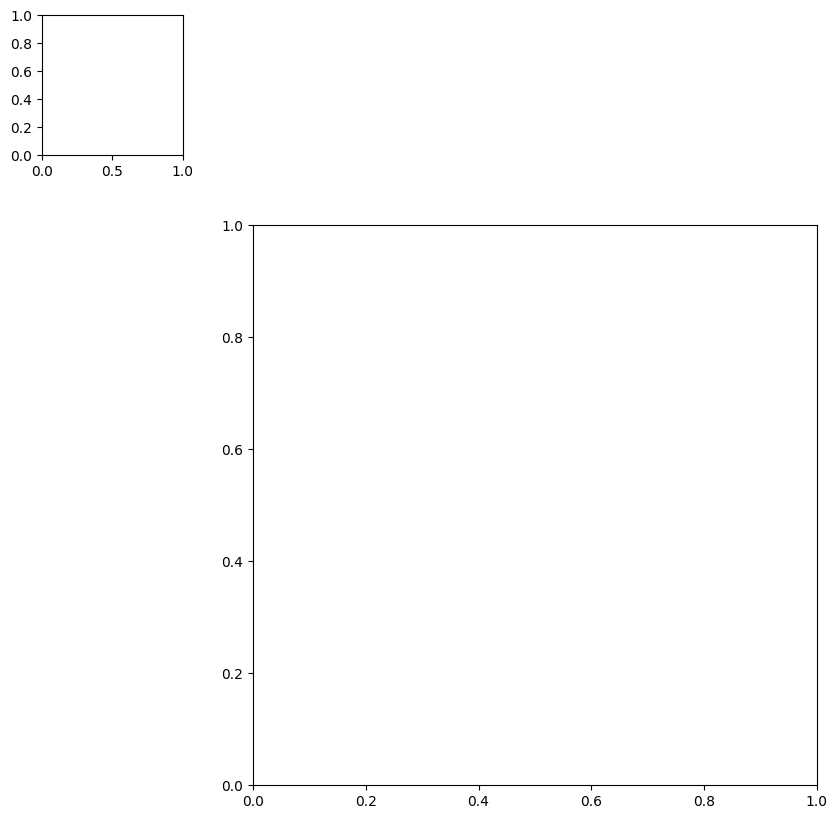

In [42]:
## Overlay heatmap for significant values with higher alpha
mask = np.array(clones_shared) < 2
sns.clustermap(
    X_fillna,
    mask = mask,
    cmap='RdBu_r',
    vmin=-1,
    vmax=1,
    center=0,
    row_linkage = all_linkage,
    col_linkage = all_linkage,
    row_cluster=True,
    col_cluster=True,
    linewidths=0.5,
    linecolor='grey',
    figsize=(10, 10),
    method = "ward"
)

title_text = "Correlations for clone co-occurance"

# Set the title
plt.title(title_text, fontsize=16)

save_plot("clone_hierarhical_correlation_concordant_heatmap")
plt.show()
plt.clf()